<a href="https://colab.research.google.com/github/silvhua/Netflix-Recommender-Engines-Challenge/blob/main/recommender_engines_II_Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
! pip install scikit-surprise
# import SVD from surprise
from surprise import SVD

# # import dataset from surprise
from surprise import Dataset
from surprise import Reader

# import accuracy from surprise
from surprise import accuracy

# import train_test_split from surprise.model_selection
from surprise.model_selection import train_test_split
# import GridSearchCV from surprise.model_selection
from surprise.model_selection import GridSearchCV
# import cross_validate from surprise.model_selection
from surprise.model_selection import cross_validate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 12.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626455 sha256=da26e84575245300219108ed6dd2a057e20debf79ec812fe64325ac72c6d4035
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


# Load Data

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])
movies.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
movies

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_1.txt', header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2])
df1.head()

,Customer,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


Data Prep

In [ ]:
# Used this as an example: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
from collections import deque 
def reshape_df(df):
    tmp_movies = df[df['Rating'].isna()]['Customer'].reset_index()
    movie_index = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

    # Shift the movie_indices by one to get start and endpoints of all movies
    shifted_movie_index = deque(movie_index)
    shifted_movie_index.rotate(-1)

    user_data = []
    for [df_id1, movie_id1], [df_id2, movie_id2] in zip(movie_index, shifted_movie_index):
        # check if last movie in the file
        if df_id1 < df_id2:
            tmp_df = df.loc[df_id1+1: df_id2-1].copy()
        else:
            tmp_df = df.loc[df_id1+1:].copy()
        # create movie_id column
        tmp_df['Movie_ID'] = movie_id1
        user_data.append(tmp_df)
    df2 = pd.concat(user_data)
    del user_data, df, tmp_df
    print('Shape:', df2.shape)
    return df2

In [ ]:
df1 = reshape_df(df1)
df1.to_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/data1_reshaped.csv')
df1.head()

Shape: (24053764, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [ ]:
df1['Movie_ID'].unique()

array([   1,    2,    3, ..., 4497, 4498, 4499])

In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df

df1 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/data1_reshaped.csv',filepath='',
               column1_as_index=True, truncate=1000000)
df1.head()

Dataframe shape:  (24053764, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


# Surprise

In [ ]:
reader = Reader(rating_scale=(1, 5))# Loads Pandas dataframe
data = Dataset.load_from_df(df1[['Customer', 'Movie_ID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=.15)
model1 = SVD()
fit_model1 = model1.fit(trainset)

In [ ]:
testset[0:5]

[('140174', 3165, 3.0),
 ('1132410', 3427, 2.0),
 ('796093', 1975, 3.0),
 ('2229253', 3925, 1.0),
 ('1226844', 1369, 2.0)]

In [ ]:
# Make predictions for first 5 users in test set
predictions1 = model1.test(testset[0:5])
predictions1
# `est` refers to predicted rating from that user (uid) for that movie (iid, or item id)

[Prediction(uid='140174', iid=3165, r_ui=3.0, est=3.4407710472274458, details={'was_impossible': False}),
 Prediction(uid='1132410', iid=3427, r_ui=2.0, est=2.812289905220415, details={'was_impossible': False}),
 Prediction(uid='796093', iid=1975, r_ui=3.0, est=2.5541376180429203, details={'was_impossible': False}),
 Prediction(uid='2229253', iid=3925, r_ui=1.0, est=3.129383801780239, details={'was_impossible': False}),
 Prediction(uid='1226844', iid=1369, r_ui=2.0, est=2.020837887324352, details={'was_impossible': False})]

In [ ]:
rmse = accuracy.rmse(predictions1)
print(f'Model RMSE on test set: {rmse:.2f}')

RMSE: 1.0571
Model RMSE on test set: 1.06


## Recommend a new movie

In [ ]:
def recommend_movie(customer_id, model, ratings=df1, movies=movies):
  """2022-12-05 19:36
  Recommend 1 movie for a given customer.
  Parameters:
    - customer_id: Customer_id
    - model: A surprise model that has been fit.
    - ratings: DataFrame containing customer ratings.
    - movies: DataFrame containing Movie_Id and title.

  """
  rated = ratings.loc[ratings['Customer']==customer_id, 'Movie_ID'].values
  unrated = np.setdiff1d(movies['Movie_Id'], rated)
  testset = [[customer_id, movie, 1] for movie in unrated]
  predictions = model.test(testset)
  predicted_ratings = np.array([pred.est for pred in predictions])
  recommendation_index = predicted_ratings.argmax()
  recommendation_movie_id = unrated[recommendation_index]
  recommendation = movies.loc[movies['Movie_Id']==recommendation_movie_id, 'Name'].values
  return recommendation


def batch_recommend(customers_df, model=model1, movies=movies):
  recommendations = pd.DataFrame(index=customers_df.index)
  rated_movie = [movies[movies['Movie_Id'] == id]['Name'].values[0] for id in customers_df['Movie_ID'].values]
  recommendations['Rated Movie'] = rated_movie
  recommendations['Recommendation'] = customers_df['Customer'].apply(lambda x: recommend_movie(x, model))
  recommendations.index.name = 'Customer'
  return recommendations


batch_recommend(df1.head(5))

,Rated Movie,Recommendation
Customer,,
1,Dinosaur Planet,[Stargate SG-1: Season 7]
2,Dinosaur Planet,[Elfen Lied]
3,Dinosaur Planet,[Sex and the City: Season 4]
4,Dinosaur Planet,[Six Feet Under: Season 4]
5,Dinosaur Planet,[Smallville: Season 1]


In [ ]:
batch_recommend(df1.tail(5))

,Rated Movie,Recommendation
Customer,,
24058258,In My Skin,[The West Wing: Season 3]
24058259,In My Skin,[Aqua Teen Hunger Force: Vol. 1]
24058260,In My Skin,[Michael Moore's The Awful Truth: Season 2]
24058261,In My Skin,[Seven Samurai]
24058262,In My Skin,[Spirited Away]


## Test with select movie titles

In [ ]:
movies.head(30)

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
6,7,1992.0,8 Man
7,8,2004.0,What the #$*! Do We Know!?
8,9,1991.0,Class of Nuke 'Em High 2
9,10,2001.0,Fighter


In [ ]:
df1[(df1['Movie_ID'] == 28) & (df1['Rating'] > 4)].head()

,Customer,Rating,Date,Movie_ID
52553,1990901,5.0,2004-02-16,28
52554,2626356,5.0,2005-07-08,28
52572,1456155,5.0,2005-07-21,28
52578,1632018,5.0,2005-07-25,28
52579,577397,5.0,2003-05-19,28


In [ ]:
# Movie_id 28 is for Lilo and Stitch; what are the recommendations for people who like that movie?
batch_recommend(df1[(df1['Movie_ID'] == 28) & (df1['Rating'] > 4)].head())

,Rated Movie,Recommendation
Customer,,
52553,Lilo and Stitch,[Chappelle's Show: Season 1]
52554,Lilo and Stitch,[Aqua Teen Hunger Force: Vol. 1]
52572,Lilo and Stitch,[The Wire: Season 1]
52578,Lilo and Stitch,[SpongeBob SquarePants: Season 2]
52579,Lilo and Stitch,[I Love Lucy: Season 2]


In [ ]:
# What are the recommendations for people who like Sesame Street: Elmo's World: ?
batch_recommend(df1[(df1['Movie_ID'] == 27) & (df1['Rating'] > 3)].head())

,Rated Movie,Recommendation
Customer,,
52277,Sesame Street: Elmo's World: The Street We Liv...,[CSI: Season 1]
52278,Sesame Street: Elmo's World: The Street We Liv...,[Ghosts of Rwanda: Frontline]
52279,Sesame Street: Elmo's World: The Street We Liv...,[Coupling: Season 1]
52281,Sesame Street: Elmo's World: The Street We Liv...,[Stargate SG-1: Season 7]
52282,Sesame Street: Elmo's World: The Street We Liv...,[Lonesome Dove]


In [ ]:
# What are the recommendations for people who like Something's Gotta Give
batch_recommend(df1[(df1['Movie_ID'] == 30) & (df1['Rating'] > 4)].head())

,Rated Movie,Recommendation
Customer,,
92828,Something's Gotta Give,[Stargate SG-1: Season 3]
92829,Something's Gotta Give,[The Recruit]
92837,Something's Gotta Give,[Friends: Season 6]
92850,Something's Gotta Give,[Aqua Teen Hunger Force: Vol. 1]
92851,Something's Gotta Give,[The O.C.: Season 1]


In [ ]:
# Recommendations for those who liked My Bloody Valentine
batch_recommend(df1[(df1['Movie_ID'] == 24) & (df1['Rating'] > 4)].head())

,Rated Movie,Recommendation
Customer,,
43896,My Bloody Valentine,[Lord of the Rings: The Return of the King: Ex...
43922,My Bloody Valentine,[Lord of the Rings: The Return of the King: Ex...
43949,My Bloody Valentine,[The Rise and Fall of ECW]
43956,My Bloody Valentine,[Dinosaur Planet]
43976,My Bloody Valentine,[Isle of Man TT 2004 Review]


In [ ]:
# Recommendations for those who liked Nature Antarctica
batch_recommend(df1[(df1['Movie_ID'] == 14) & (df1['Rating'] > 4)].head())

,Rated Movie,Recommendation
Customer,,
21239,Nature: Antarctica,[Reno 911: Season 2]
21246,Nature: Antarctica,[Isle of Man TT 2004 Review]
21251,Nature: Antarctica,[The Best of Friends: Vol. 4]
21256,Nature: Antarctica,[The West Wing: Season 3]
21262,Nature: Antarctica,[Princess Mononoke]


# User-to-user memory-based collaborative filtering

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])
movies.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_1.txt', 
    header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2]).truncate(after=100000)
df1.head()

,Customer,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [ ]:
# Used this as an example: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
def reshape_df(df, movie_index, shifted_movie_index):
    user_data = []
    for [df_id1, movie_id1], [df_id2, movie_id2] in zip(movie_index, shifted_movie_index):
        # check if last movie in the file
        if df_id1 < df_id2:
            tmp_df = df.loc[df_id1+1: df_id2-1].copy()
        else:
            tmp_df = df.loc[df_id1+1:].copy()
        # create movie_id column
        tmp_df['Movie_ID'] = movie_id1
        user_data.append(tmp_df)
    df2 = pd.concat(user_data)
    del user_data, df, tmp_df
    print('Shape:', df2.shape)
    return df2

tmp_movies = df1[df1['Rating'].isna()]['Customer'].reset_index()
movie_index = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
from collections import deque 
shifted_movie_indices = deque(movie_index)
shifted_movie_indices.rotate(-1)

df1 = reshape_df(df1, movie_index, shifted_movie_indices)
del tmp_movies
df1.head()

Shape: (99971, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [ ]:
df1['Movie_ID'].value_counts()

28    39752
8     14910
18    10722
30     7173
17     7108
26     5861
16     2699
3      2012
24     1333
25     1207
5      1140
6      1019
23      615
1       547
12      546
19      539
29      523
15      290
27      273
10      249
21      218
22      203
11      198
2       145
4       142
13      125
14      118
20      116
9        95
7        93
Name: Movie_ID, dtype: int64

## Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
customers = df1.sample(frac=0.05, random_state=0).pivot_table(index='Customer', columns='Movie_ID', values='Rating')
print(customers.shape)
customers.head()

(4939, 30)


Movie_ID,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Customer,,,,,,,,,,,,,,,,,,,,,
1000868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1002494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1002870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1003172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [ ]:
customers = customers.fillna(0)
cosine_sim = cosine_similarity(customers, customers)


In [ ]:
print(customers.shape)
print(cosine_sim.shape)

(1000, 8)
(1000, 1000)


In [ ]:
cosine_sim[0]

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1.

In [ ]:
# I realize now that cosine similarity won't work given that most users haven't rated most movies.

## KNeighbors

In [ ]:
import pickle
def savepickle(model,filename, ext='sav', path='/content/drive/MyDrive/data exercises/W10/netflix-challenge/',append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - extension: Extension to append (do not include dot as it will be added)
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename+'.'+ext, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+'.'+ext)

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [ ]:
customers = df1.pivot_table(index='Customer', columns='Movie_ID', values='Rating')
print(customers.shape)
customers.head()

(283670, 225)


Movie_ID,1,2,3,4,5,6,7,8,9,10,...,216,217,218,219,220,221,222,223,224,225
Customer,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
customers = customers.fillna(0)

In [ ]:
customers

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,216,217,218,219,220,221,222,223,224,225
Customer,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
savepickle(customers, 'Exp1_user-user_utilty_matrix')

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//Exp1_user-user_utilty_matrix.sav


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(customers)
savepickle(neigh, 'saved_models/kneighbor_user-user')

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//saved_models/kneighbor_user-user.sav


In [ ]:
def uu_kn_recommend(ratings, ratings_table, model, movies=movies):
  """updated 2022-12-25
  Recommend movies for a given user. 
  Parameters:
    - customer (int): Customer ID for a single customer. Must by an array, i.e. put in square brackets.
    - ratings_table: Dense matrix of movie ratings with customers as rows and movies as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  """
  movie_id = ratings.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings.loc['Customer']
  customer_ratings = ratings_table.loc[customer]
  rated_movies = customer_ratings[customer_ratings != 0].index
  
  # Find similar users based on movie ratings
  neighbors = model.kneighbors(ratings_table.loc[[customer]], return_distance=False).ravel()

  # Filter the ratings table to only show rows with most similar customers
  filtered_table = ratings_table.iloc[neighbors]
  # Transpose the table so each row is for a movie. 
  movie_ratings = filtered_table.transpose()
  # Get the sum of all similar users' ratings per movie
  movie_ratings['sum'] = movie_ratings.sum(axis=1)

  # Sort movies by sum
  sorted_movies_list = movie_ratings.sort_values('sum', ascending=False).index.to_list()
  # print(sorted_movies_list)

  # Remove movies that the user has already rated
  new_movies = [movie for movie in sorted_movies_list if movie not in rated_movies]
  recommendation = movies[movies['Movie_Id'] == new_movies[0]]['Name'].values[0]
  return pd.Series([rated_movie_title, recommendation], index=['Rated Movie', 'Recommended Movie'])

def run_uu_kn_recommend(ratings_df, ratings_table=customers, model=neigh, movies=movies):
  """updated 2022-12-25
  Make recommendations for several customers.

  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.
    - customer_matrix: Dense matrix of movie ratings with customers as rows and movies as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  """
  results = ratings_df.transpose().apply(lambda x: uu_kn_recommend(x, ratings_table, model,
    movies)).transpose()
  recommendations = pd.concat([ratings_df['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return results

In [ ]:
# run the recommendation on half of the customers to see the distribution of recommendations
run_uu_kn_recommend(df1.sample(100, random_state=0))

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

,Rated Movie,Recommended Movie
284858,Maya Lin: A Strong Clear Vision,The Strongest Man in the World
974510,Chappelle's Show: Season 1,Demon Warrior Koji
74606,Lilo and Stitch,Death to Smoochy
718703,X2: X-Men United,Demon Warrior Koji
273212,Dragonheart,Rambo: First Blood Part II
...,...,...
654879,Reservoir Dogs,Death to Smoochy
865475,Taking Lives,Chappelle's Show: Season 1
282179,Invader Zim,Taking Lives
999448,The Cookout,Dominion Tank Police Part 1 & 2


# Item-to-item memory-based collaborative filtering

## KNeighbors

In [ ]:
movies_matrix = df1.pivot_table(index='Movie_ID', columns='Customer', values='Rating')
print(movies_matrix.shape)
movies_matrix.head()

(225, 283670)


Customer,6,7,10,25,33,42,59,79,87,94,...,2649370,2649375,2649376,2649378,2649388,2649401,2649404,2649409,2649426,2649429
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.neighbors import NearestNeighbors
movies_matrix = movies_matrix.fillna(0)
savepickle(movies_matrix,'Exp1_item-item_utilty_matrix')

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//Exp1_item-item_utilty_matrix.sav


In [ ]:
neigh2 = NearestNeighbors(n_neighbors=3) # n_neighbors=3 to only recommend 3 movies.
neigh2.fit(movies_matrix)
savepickle(neigh2, 'kneighbor_item-item')

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//kneighbor_item-item.sav


In [ ]:
def uu_kn_recommend3(ratings, ratings_table, model, movies=movies):
  """Updated 2022-12-25
  Recommend movies most similar to a given movie. 
  Parameters:
    - ratings: DataFrame with Customer and Movie_ID
    - ratings_table: Dense matrix of movie ratings with movies as rows and customers as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  """
  movie_id = ratings.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings.loc['Customer']
  rated_movies = ratings_table[ratings_table[customer] !=0].index

  # Find similar movies based on movie ratings
  neighbors = model.kneighbors(ratings_table.loc[[movie_id]], return_distance=False).ravel()

  # Filter the ratings table to only show rows with most similar movies; index is the movie_id
  similar_movies = ratings_table.iloc[neighbors].index
  try:
    recommended_movies_id = [movie for movie in similar_movies if movie not in rated_movies][0]
    recommendation = movies[movies['Movie_Id'] == recommended_movies_id]['Name'].values
    return pd.Series([rated_movie_title, recommendation], index=['Rated Movie', 'Recommended Movie'])
  except:
    return pd.Series([rated_movie_title, None], index=['Rated Movie', 'Recommended Movie'])

def run_uu_kn_recommend3(ratings_df, ratings_table=movies_matrix, model=neigh2, movies=movies):
  """Updated 2022-12-25
  Recommend one movie.
  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.
    - ratings_table: Dense matrix of movie ratings with movies as rows and customers as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  Returns:
    - DataFrame containing a single new movie recommendation for each customer.
  """
  results = ratings_df.transpose().apply(lambda x: uu_kn_recommend3(x, ratings_table, model)
    ).transpose()
  recommendations = pd.concat([ratings_df['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return results


run_uu_kn_recommend3(df1.head(4))


**Input movies count**: 1
Dinosaur Planet    4
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
[Horror Vision]    4
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Rated Movie,Recommended Movie
1,Dinosaur Planet,[Horror Vision]
2,Dinosaur Planet,[Horror Vision]
3,Dinosaur Planet,[Horror Vision]
4,Dinosaur Planet,[Horror Vision]


In [ ]:
# run the recommendation on many customers to see the distribution of recommendations
recommend2 = run_uu_kn_recommend3(df1.sample(100, random_state=0))

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

In [ ]:
recommend2

,Rated Movie,Recommended Movie
284858,Maya Lin: A Strong Clear Vision,[Horror Vision]
974510,Chappelle's Show: Season 1,[MTV: Making the Band 2: Best of Season 1]
74606,Lilo and Stitch,[The Powerpuff Girls Movie]
718703,X2: X-Men United,[Dragonheart]
273212,Dragonheart,[Screamers]
...,...,...
654879,Reservoir Dogs,None
865475,Taking Lives,[Spartan]
282179,Invader Zim,[Horror Vision]
999448,The Cookout,[Horror Vision]


### Filter out movies with ratings below threshold

In [ ]:
import pandas as pd
import numpy as np
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])
movies.head()

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_1.txt', 
    header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2]).truncate(after=200000)
print(df1.shape)

(200001, 3)


In [ ]:
# Used this as an example: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
def reshape_df(df, movie_index, shifted_movie_index):
    user_data = []
    for [df_id1, movie_id1], [df_id2, movie_id2] in zip(movie_index, shifted_movie_index):
        # check if last movie in the file
        if df_id1 < df_id2:
            tmp_df = df.loc[df_id1+1: df_id2-1].copy()
        else:
            tmp_df = df.loc[df_id1+1:].copy()
        # create movie_id column
        tmp_df['Movie_ID'] = movie_id1
        user_data.append(tmp_df)
    df2 = pd.concat(user_data)
    del user_data, df, tmp_df
    print('Shape:', df2.shape)
    return df2

tmp_movies = df1[df1['Rating'].isna()]['Customer'].reset_index()
movie_index = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
from collections import deque 
shifted_movie_indices = deque(movie_index)
shifted_movie_indices.rotate(-1)

df1 = reshape_df(df1, movie_index, shifted_movie_indices)
del tmp_movies
df1.head()

Shape: (199971, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [ ]:
movies_matrix2 = df1.pivot_table(index='Movie_ID', columns='Customer', values='Rating')
print(movies_matrix2.shape)
movies_matrix2.head()

(30, 150677)


Customer,1000033,1000038,100006,1000062,1000079,1000094,1000104,1000105,1000153,1000158,...,999836,999892,999894,999895,999901,999907,999913,99993,999935,999988
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter out movies with average rating < 3 and fewer than a certain number of ratings
movies_matrix2 = movies_matrix2[(movies_matrix2.mean(axis=1) > 3.5) & (movies_matrix2.count(axis=1) > 500)]

In [ ]:
movies_matrix2.shape

(9, 150677)

In [ ]:
from sklearn.neighbors import NearestNeighbors
movies_matrix2 = movies_matrix2.fillna(0)
neigh3 = NearestNeighbors(n_neighbors=3) # n_neighbors=3 to only recommend 3 movies.
neigh3.fit(movies_matrix2)

NearestNeighbors(n_neighbors=3)

In [ ]:
def uu_kn_recommend4(ratings, ratings_table, model, movies=movies):
  """
  Recommend movies most similar to a given movie. 
  Parameters:
    - ratings: DataFrame with Customer and Movie_ID
    - ratings_table: Dense matrix of movie ratings with movies as rows and customers as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  """
  movie_id = ratings.loc['Movie_ID']
  customer = ratings.loc['Customer']
  rated_movies = ratings_table[ratings_table[customer] !=0].index

  # Find similar movies based on movie ratings
  try:
    neighbors = model.kneighbors(ratings_table.loc[[movie_id]], return_distance=False).ravel()
  except:
    return None

  # Filter the ratings table to only show rows with most similar movies; index is the movie_id
  similar_movies = ratings_table.iloc[neighbors].index
  try:
    recommended_movies_id = [movie for movie in similar_movies if movie not in rated_movies][0]
    recommended_movies = movies[movies['Movie_Id'] == recommended_movies_id]['Name'].values
    return recommended_movies 
  except:
    return None

def run_uu_kn_recommend4(ratings_df, ratings_table=movies_matrix, model=neigh2, movies=movies):
  """
  Recommend one movie.
  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.
    - ratings_table: Dense matrix of movie ratings with movies as rows and customers as columns.
    - model: NearestNeighbors instance that has been fit.
    - movies: DataFrame containing movie info.
  Returns:
    - DataFrame containing a single new movie recommendation for each customer.
  """
  results = ratings_df.transpose().apply(lambda x: uu_kn_recommend4(x, ratings_table, model)
    ).transpose()
  results.columns=['Recommendation']
  return results

# run the recommendation on many customers to see the distribution of recommendations
recommend3 = run_uu_kn_recommend4(df1.sample(frac=0.0005, random_state=0), ratings_table=movies_matrix2, model=neigh3)
recommend3['Recommendation'].value_counts()

Boycott                                                                 55
Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo    28
Name: Recommendation, dtype: int64

In [ ]:
recommend3

,Recommendation
86167,Clifford: Clifford Saves the Day! / Clifford's...
180210,Boycott
54827,Clifford: Clifford Saves the Day! / Clifford's...
79030,Clifford: Clifford Saves the Day! / Clifford's...
67526,Clifford: Clifford Saves the Day! / Clifford's...
...,...
10085,None
83775,Clifford: Clifford Saves the Day! / Clifford's...
140683,Boycott
20806,None


## Cosine similarity

In [ ]:
movies_matrix2 = df1.pivot_table(index='Movie_ID', columns='Customer', values='Rating')

In [ ]:
movies_matrix2.mean(axis=1)

Movie_ID
1      3.749543
2      3.558621
3      3.641153
4      2.739437
5      3.919298
         ...   
221    3.434783
222    2.606061
223    4.211192
224    3.831492
225    2.731875
Length: 225, dtype: float64

In [ ]:
print(movies_matrix.shape)
# Filter out movies with average rating < 3 and fewer than a certain number of ratings
min_rating = 3.5
min_rating_count = 100
movies_matrix4 = movies_matrix2[(movies_matrix2.mean(axis=1) > min_rating) & (
    movies_matrix2.count(axis=1) > min_rating_count)]
print(movies_matrix4.shape)

movies_matrix4.head()

(225, 283670)
(66, 283670)


Customer,6,7,10,25,33,42,59,79,87,94,...,2649370,2649375,2649376,2649378,2649388,2649401,2649404,2649409,2649426,2649429
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
movies_matrix4 = movies_matrix4.fillna(0)
cosine_sim2 = cosine_similarity(movies_matrix4, movies_matrix4)
cosine_sim2.shape

(66, 66)

In [ ]:
cosine_sim2

array([[1.        , 0.01493888, 0.00920994, ..., 0.02769752, 0.02308313,
        0.01720954],
       [0.01493888, 1.        , 0.00649565, ..., 0.00973789, 0.01324753,
        0.01013852],
       [0.00920994, 0.00649565, 1.        , ..., 0.01257088, 0.02249369,
        0.02733631],
       ...,
       [0.02769752, 0.00973789, 0.01257088, ..., 1.        , 0.15468678,
        0.01200492],
       [0.02308313, 0.01324753, 0.02249369, ..., 0.15468678, 1.        ,
        0.0075399 ],
       [0.01720954, 0.01013852, 0.02733631, ..., 0.01200492, 0.0075399 ,
        1.        ]])

In [ ]:
def recommend_similar(ratings_input, similarity_matrix, movies, all_ratings, movie_indices):
  """
  updated 2022-12-25
  """
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  matrix_index = movie_indices[movie_indices == movie_id]
  sorted_indices = similarity_matrix[matrix_index].argsort()
  closest_indices = sorted_indices[-3:] # 3 most similar
  rated_movies = all_ratings[all_ratings['Customer'] == customer]['Movie_ID'].values
  recommend_movie_id = [movie_indices[closest_index] for closest_index in closest_indices if movie_indices[closest_index] not in rated_movies]
  recommendation = str(recommend_movie_id[0])+': '+movies[movies['Movie_Id'] == recommend_movie_id[0]]['Name'].values
  return pd.Series([rated_movie_title, recommendation], index=['Rated Movie', 'Recommended Movie'])


def batch_recommend_similar(ratings_input, similarity_matrix=cosine_sim2,
        movies=movies, all_ratings=df1, movie_indices=movies_matrix4.index.to_list()):
  """updated 2022-12-25
  Recommend one movie.
  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.
    - similarity_matrix: Cosine similarity matrix
    - movies: DataFrame containing movie info.
  Returns:
    - DataFrame containing a single new movie recommendation for each customer.
  """
  results = ratings_input.transpose().apply(lambda x: recommend_similar(x, 
    similarity_matrix, movies, all_ratings, movie_indices)).transpose()
  recommendations = pd.concat([ratings_input['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return recommendations

batch_recommend_similar(df1.sample(5, random_state=0))

**Input movies count**: 5
Maya Lin: A Strong Clear Vision    1
Chappelle's Show: Season 1         1
Lilo and Stitch                    1
X2: X-Men United                   1
Dragonheart                        1
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
[27: Sesame Street: Elmo's World: The Street We Live On]    5
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Customer,Rated Movie,Recommended Movie
284858,2013826,Maya Lin: A Strong Clear Vision,[27: Sesame Street: Elmo's World: The Street W...
974510,762713,Chappelle's Show: Season 1,[27: Sesame Street: Elmo's World: The Street W...
74606,1879529,Lilo and Stitch,[27: Sesame Street: Elmo's World: The Street W...
718703,1886185,X2: X-Men United,[27: Sesame Street: Elmo's World: The Street W...
273212,258937,Dragonheart,[27: Sesame Street: Elmo's World: The Street W...


In [ ]:
batch_recommend_similar(df1.sample(100, random_state=0))

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

,Customer,Rated Movie,Recommended Movie
284858,2013826,Maya Lin: A Strong Clear Vision,[27: Sesame Street: Elmo's World: The Street W...
974510,762713,Chappelle's Show: Season 1,[27: Sesame Street: Elmo's World: The Street W...
74606,1879529,Lilo and Stitch,[27: Sesame Street: Elmo's World: The Street W...
718703,1886185,X2: X-Men United,[27: Sesame Street: Elmo's World: The Street W...
273212,258937,Dragonheart,[27: Sesame Street: Elmo's World: The Street W...
...,...,...,...
654879,2312452,Reservoir Dogs,[27: Sesame Street: Elmo's World: The Street W...
865475,1470232,Taking Lives,[27: Sesame Street: Elmo's World: The Street W...
282179,2032423,Invader Zim,[27: Sesame Street: Elmo's World: The Street W...
999448,1702217,The Cookout,[27: Sesame Street: Elmo's World: The Street W...


# Content-based collaborative filtering

## apyori

In [ ]:
! pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5973 sha256=ed3b8ff440d1f631fda5511230b0c909be1475443fd6a63d9c69624e4b153c3c
  Stored in directory: /root/.cache/pip/wheels/1b/02/6c/a45230be8603bd95c0a51cd2b289aefdd860c1a100eab73661
Successfully built apyori


In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df

df1 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/data1_reshaped.csv',filepath='',
               column1_as_index=True, truncate=500000)
# tried with 1,000,000 samples but even with premium GPU, was unable to complete processing after 
# several hours and running out of GPU compute hours
df1.head()

Dataframe shape:  (24053764, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [ ]:
import pickle
def savepickle(model,filename, ext='sav', path='/content/drive/MyDrive/data exercises/W10/netflix-challenge/',append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - extension: Extension to append (do not include dot as it will be added)
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename+'.'+ext, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+'.'+ext)

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [ ]:
from apyori import apriori
def make_apriori_df(ratings, min_confidence, min_lift, min_ratings=None, min_support=None):
  """
  Convert movie ratings into dataframe with apriori association results.
  """
  print('Number of ratings:', len(ratings))
  rated_movies = [ratings[ratings['Customer'] == id]['Movie_ID'].to_list() for id in ratings['Customer'].unique()]
  print('Number of rated movies:', len(rated_movies))
  min_support = min_ratings/len(rated_movies) if min_ratings else min_support

  association_rules = apriori(rated_movies, min_length=2, min_support=min_support,
      min_confidence=min_confidence, min_lift=min_lift)
  association_results = list(association_rules)
  print(f'Number of association rules: {len(association_results)}')
  results = []
  for item in association_results:
      # first index of the inner list contains base item and add item.
      # A pair may contain more than 2 items because each "item" in the pair can contain more than 1 movie.
      pair = item[0]
      items = [item for item in pair]
      title1 = str(items[0])
      title2 = str(items[1])
      support = item[1]
      #third index of the list located at 0th of the third index of the inner list
      confidence = item[2][0][2]
      lift = item[2][0][3]
      rows = (title1, title2, support, confidence, lift)
      results.append(rows)
  labels = ['Title 1','Title 2','Support','Confidence','Lift']
  return pd.DataFrame.from_records(results, columns = labels)


min_ratings = 100
min_confidence = 0.2
min_lift = 1.3

apriori_df = make_apriori_df(df1, min_confidence, min_lift, min_ratings=min_ratings)
apriori_df


Number of ratings: 499853
Number of rated movies: 214992
Number of association rules: 13648


,Title 1,Title 2,Support,Confidence,Lift
0,1,28,0.001037,0.407678,2.204859
1,1,58,0.000758,0.297989,3.680854
2,1,77,0.000614,0.241316,3.815345
3,1,111,0.000516,0.202925,1.448112
4,1,118,0.000637,0.250457,2.798662
...,...,...,...,...,...
13643,108,44,0.000470,0.207819,71.145553
13644,108,44,0.000498,0.251174,85.987799
13645,77,46,0.000465,0.218341,114.491426
13646,108,77,0.000484,0.254279,56.533498


In [ ]:
savepickle(apriori_df, 'apriori_dataframe')

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//apriori_dataframe.sav


In [ ]:
from apyori import apriori
import pandas as pd
import numpy as np
apriori_df = loadpickle('apriori_dataframe.sav', 
                        filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/')
apriori_df

,Title 1,Title 2,Support,Confidence,Lift
0,1,28,0.001037,0.407678,2.204859
1,1,58,0.000758,0.297989,3.680854
2,1,77,0.000614,0.241316,3.815345
3,1,111,0.000516,0.202925,1.448112
4,1,118,0.000637,0.250457,2.798662
...,...,...,...,...,...
13643,108,44,0.000470,0.207819,71.145553
13644,108,44,0.000498,0.251174,85.987799
13645,77,46,0.000465,0.218341,114.491426
13646,108,77,0.000484,0.254279,56.533498


In [ ]:
print(len(apriori_df['Title 1'].unique()))
print(len(apriori_df['Title 2'].unique()))

80
71


In [ ]:
def recommend_apriori(ratings_input, apriori_df, movies):
  
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  try:
    recommendation_id = int(apriori_df.loc[apriori_df['Title 1'] == str(movie_id), 'Title 2'].values[0])
    recommendation = movies.loc[movies['Movie_Id'] == recommendation_id, 'Name'].values[0]
    return pd.Series([rated_movie_title, recommendation], index=['Rated Movie', 'Recommended Movie'])
  except:
    return pd.Series([rated_movie_title, None], index=['Rated Movie', 'Recommended Movie'])

def batch_recommend_aprior(ratings_input, apriori_df=apriori_df.sort_values('Lift', ascending=False), 
                           movies=movies):
  """
  Default is to sort apriori_df by 'Lift'
  """
  results = ratings_input.transpose().apply(lambda x: recommend_apriori(x, 
    apriori_df, movies)).transpose()
  recommendations = pd.concat([ratings_input['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return recommendations

batch_recommend_aprior(df1.head())

**Input movies count**: 1
Dinosaur Planet    5
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
Dragonheart    5
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Customer,Rated Movie,Recommended Movie
1,1488844,Dinosaur Planet,Dragonheart
2,822109,Dinosaur Planet,Dragonheart
3,885013,Dinosaur Planet,Dragonheart
4,30878,Dinosaur Planet,Dragonheart
5,823519,Dinosaur Planet,Dragonheart


In [ ]:
apriori_recommendations = batch_recommend_aprior(df1.sample(100,random_state=0))
apriori_recommendations

**Input movies count**: 35
Something's Gotta Give                                                 24
The Game                                                                8
Duplex (Widescreen)                                                     7
Dragonheart                                                             7
Lilo and Stitch                                                         5
Rambo: First Blood Part II                                              5
Mostly Martha                                                           4
Jingle All the Way                                                      3
Silkwood                                                                3
What the #$*! Do We Know!?                                              3
Scandal                                                                 2
Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985     2
Daydream Obsession                                                      2
Spitfire Gr

,Customer,Rated Movie,Recommended Movie
409359,679943,Duplex (Widescreen),The Game
447699,1571327,Lucio Fulci: The Beyond,Something's Gotta Give
186052,1022808,Something's Gotta Give,None
6647,2222702,What the #$*! Do We Know!?,Richard III
146447,1396650,Something's Gotta Give,None
...,...,...,...
163242,1150774,Something's Gotta Give,None
96433,291687,Something's Gotta Give,None
357933,846266,Stevie Ray Vaughan and Double Trouble: Live at...,Rambo: First Blood Part II
304446,2411332,Jingle All the Way,Rudolph the Red-Nosed Reindeer


In [ ]:
# Sort apriori recommendations by Confidence
apriori_recommendations2 = batch_recommend_aprior(df1.sample(100, random_state=0), 
        apriori_df=apriori_df.sort_values('Confidence', ascending=False))
apriori_recommendations2

**Input movies count**: 35
Something's Gotta Give                                                 24
The Game                                                                8
Duplex (Widescreen)                                                     7
Dragonheart                                                             7
Lilo and Stitch                                                         5
Rambo: First Blood Part II                                              5
Mostly Martha                                                           4
Jingle All the Way                                                      3
Silkwood                                                                3
What the #$*! Do We Know!?                                              3
Scandal                                                                 2
Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985     2
Daydream Obsession                                                      2
Spitfire Gr

,Customer,Rated Movie,Recommended Movie
409359,679943,Duplex (Widescreen),Something's Gotta Give
447699,1571327,Lucio Fulci: The Beyond,Something's Gotta Give
186052,1022808,Something's Gotta Give,None
6647,2222702,What the #$*! Do We Know!?,Spitfire Grill
146447,1396650,Something's Gotta Give,None
...,...,...,...
163242,1150774,Something's Gotta Give,None
96433,291687,Something's Gotta Give,None
357933,846266,Stevie Ray Vaughan and Double Trouble: Live at...,Rambo: First Blood Part II
304446,2411332,Jingle All the Way,Never Die Alone


## Word2Vec

In [ ]:
from gensim.models import Word2Vec
def train_w2v(ratings_input, min_count=10, pickle_name=None,):
  """
  Parameters:
    - min_count: parameter for Word2Vec model
  Returns:
    - Trained word2vec model
  """
  rated_movies = [df1[df1['Customer'] == id]['Movie_ID'].to_list() for id in ratings_input['Customer'].unique()]
  # Data needs to be converted from a list to a format that word2vec accepts
  word2vec = Word2Vec(pd.Series([[str(movie) for movie in customer] for customer in rated_movies]),
    min_count=min_count)
  if pickle_name:
    filepath = r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
    try:
      savepickle(word2vec, pickle_name+'_W2V_model', path=filepath)
    except:
      print('Output not saved')
  return word2vec


In [ ]:
word2vec = train_w2v(df1)

In [ ]:
filepath = r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
pickle_name='Word2Vec'
savepickle(word2vec, pickle_name+'_W2V_model', path=filepath)

File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models//Word2Vec_W2V_model.sav


In [ ]:
word2vec.wv.vocab

{'1': <gensim.models.keyedvectors.Vocab at 0x7f531826f820>,
 '8': <gensim.models.keyedvectors.Vocab at 0x7f531826f8b0>,
 '17': <gensim.models.keyedvectors.Vocab at 0x7f531826f880>,
 '30': <gensim.models.keyedvectors.Vocab at 0x7f531826f9a0>,
 '44': <gensim.models.keyedvectors.Vocab at 0x7f531826fa00>,
 '58': <gensim.models.keyedvectors.Vocab at 0x7f531826fa60>,
 '76': <gensim.models.keyedvectors.Vocab at 0x7f531826fac0>,
 '80': <gensim.models.keyedvectors.Vocab at 0x7f531826fb20>,
 '81': <gensim.models.keyedvectors.Vocab at 0x7f531826fb80>,
 '83': <gensim.models.keyedvectors.Vocab at 0x7f531826fbe0>,
 '108': <gensim.models.keyedvectors.Vocab at 0x7f531826fc40>,
 '111': <gensim.models.keyedvectors.Vocab at 0x7f531826fca0>,
 '118': <gensim.models.keyedvectors.Vocab at 0x7f531826fd00>,
 '143': <gensim.models.keyedvectors.Vocab at 0x7f531826fd60>,
 '5': <gensim.models.keyedvectors.Vocab at 0x7f531826fdc0>,
 '114': <gensim.models.keyedvectors.Vocab at 0x7f531826fe20>,
 '18': <gensim.models.

In [ ]:
def recommend_w2v(ratings_input, word2vec, all_ratings, movies):
  """
  Recommend a movie based on the customer and the movie that the customer rated. 
  Recommendation excludes movies already rated by the customer.
  Parameters:
    - ratings_input: Input data with customer, movie_id.
    - word2vec: word2vec instance that has been fit.
    - all_rating: Dataframe with all ratings in data set.
    - movies: DataFrame with movie titles.
  """  
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  rated_movies = all_ratings[all_ratings['Customer'] == customer]['Movie_ID']
  # print(rated_movies)
  try:
    recommendation_id_list = [item[0] for item in word2vec.wv.most_similar(str(movie_id), topn=5)]
    unseen_recommendations = [movie for movie in recommendation_id_list if movie not in rated_movies]
    recommendation = movies.loc[movies['Movie_Id'] == int(unseen_recommendations[0]), 'Name'].values[0]
    # print(recommendation_id_list)
    # print(unseen_recommendations)
    return pd.Series([rated_movie_title, recommendation], index=['Rated Movie', 'Recommended Movie'])
  except:
    return pd.Series([rated_movie_title, None], index=['Rated Movie', 'Recommended Movie'])

def batch_recommend_w2v(ratings_input, word2vec=word2vec, all_ratings=df1, 
                           movies=movies):
  """
  Parameters:
    - ratings_input: Dataframe with ratings.
    - word2vec: word2vec instance that has been fit.
    - movies: DataFrame with movie titles.
  """
  results = ratings_input.transpose().apply(lambda x: recommend_w2v(x, 
    word2vec, all_ratings, movies)).transpose()
  recommendations = pd.concat([ratings_input['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return recommendations

batch_recommend_w2v(df1.head())

**Input movies count**: 1
Dinosaur Planet    5
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
8 Man    5
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Customer,Rated Movie,Recommended Movie
1,1488844,Dinosaur Planet,8 Man
2,822109,Dinosaur Planet,8 Man
3,885013,Dinosaur Planet,8 Man
4,30878,Dinosaur Planet,8 Man
5,823519,Dinosaur Planet,8 Man


In [ ]:
batch_recommend_w2v(df1.sample(100, random_state=0))

**Input movies count**: 35
Something's Gotta Give                                                 24
The Game                                                                8
Duplex (Widescreen)                                                     7
Dragonheart                                                             7
Lilo and Stitch                                                         5
Rambo: First Blood Part II                                              5
Mostly Martha                                                           4
Jingle All the Way                                                      3
Silkwood                                                                3
What the #$*! Do We Know!?                                              3
Scandal                                                                 2
Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985     2
Daydream Obsession                                                      2
Spitfire Gr

,Customer,Rated Movie,Recommended Movie
409359,679943,Duplex (Widescreen),Sweet November
447699,1571327,Lucio Fulci: The Beyond,Mr. Vampire
186052,1022808,Something's Gotta Give,Spitfire Grill
6647,2222702,What the #$*! Do We Know!?,Boycott
146447,1396650,Something's Gotta Give,Spitfire Grill
...,...,...,...
163242,1150774,Something's Gotta Give,Spitfire Grill
96433,291687,Something's Gotta Give,Spitfire Grill
357933,846266,Stevie Ray Vaughan and Double Trouble: Live at...,Sanford and Son: Season 6
304446,2411332,Jingle All the Way,Fatal Beauty


# Randomized SVD

In [ ]:
import pandas as pd
import numpy as np
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_1.txt', 
    header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2]).truncate(after=100000)

# Used this as an example: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
def reshape_df(df, movie_index, shifted_movie_index):
    user_data = []
    for [df_id1, movie_id1], [df_id2, movie_id2] in zip(movie_index, shifted_movie_index):
        # check if last movie in the file
        if df_id1 < df_id2:
            tmp_df = df.loc[df_id1+1: df_id2-1].copy()
        else:
            tmp_df = df.loc[df_id1+1:].copy()
        # create movie_id column
        tmp_df['Movie_ID'] = movie_id1
        user_data.append(tmp_df)
    df2 = pd.concat(user_data)
    del user_data, df, tmp_df
    print('Shape:', df2.shape)
    return df2

tmp_movies = df1[df1['Rating'].isna()]['Customer'].reset_index()
movie_index = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
from collections import deque 
shifted_movie_indices = deque(movie_index)
shifted_movie_indices.rotate(-1)

df1 = reshape_df(df1, movie_index, shifted_movie_indices)
del tmp_movies
df1.head()

Shape: (99971, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [ ]:
utility_matrix = df1.pivot_table(index='Customer', columns='Movie_ID', values='Rating')
print(utility_matrix .shape)
utility_matrix .head()

(81473, 30)


Movie_ID,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Customer,,,,,,,,,,,,,,,,,,,,,
100006,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1000105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1000158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1000192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN


## Perform SVD

Predict rating based on [Sci-kit Surprise's SVD algorithm](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms): 
rui = mu + bu + bi + qi'*pu

In [ ]:
# Based on W10d2 example
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import csr_matrix


def run_svd2(matrix, n_components):
  U, Sigma, VT = randomized_svd(matrix, n_components=n_components, random_state=0)
  print('U shape: ',U.shape)
  print('Sigma shape: ', Sigma.shape)
  print('V shape: ',VT.shape)
  return U, Sigma, VT

users_matrix2, sigma2, movies_matrix2 = run_svd2(csr_matrix(utility_matrix.fillna(0)), 10)

U shape:  (81473, 10)
Sigma shape:  (10,)
V shape:  (10, 30)


In [ ]:
np.dot(users_matrix2, movies_matrix2)

array([[ 6.17521483e-05,  2.69028133e-05,  1.77686571e-02, ...,
        -6.05668772e-05,  1.79000673e-04, -6.67262227e-05],
       [ 1.29678436e-06, -1.29633275e-06, -4.03763786e-05, ...,
         2.56718428e-03, -3.38443950e-06, -1.19880096e-04],
       [ 2.59356872e-06, -2.59266551e-06, -8.07527572e-05, ...,
         5.13436857e-03, -6.76887901e-06, -2.39760191e-04],
       ...,
       [ 7.29956391e-06,  4.85570673e-06, -2.25188542e-04, ...,
        -1.91089097e-04,  5.58457683e-06, -1.39577862e-04],
       [ 1.07926356e-05,  1.09707612e-06, -2.15031197e-04, ...,
        -1.92351358e-04,  1.80861839e-05, -7.49337778e-05],
       [ 5.47467293e-06,  3.64178005e-06, -1.68891407e-04, ...,
        -1.43316823e-04,  4.18843262e-06, -1.04683396e-04]])

In [ ]:
# Reconstruct the decomposed matrix
reconst = users_matrix2.dot(np.diag(sigma2)).dot(movies_matrix2)

In [ ]:
reconst[0][2]

2.9965347622865552

In [ ]:
reconst[0][4]

-0.004542261038681522

In [ ]:
reconst[0][0]

0.012026183342596244

In [ ]:
# mean rating per user
print(utility_matrix.mean(axis=1).shape)
utility_matrix.mean(axis=1)

(81473,)


Customer
100006     3.0
1000079    2.0
1000105    4.0
1000158    3.0
1000192    2.0
          ... 
999895     3.0
999901     5.0
999907     4.0
999913     2.0
999935     3.0
Length: 81473, dtype: float64

In [ ]:
# mean rating per movie
print(utility_matrix.mean().shape)
utility_matrix.mean()

(30,)


Movie_ID
1     3.749543
2     3.558621
3     3.641153
4     2.739437
5     3.919298
6     3.084396
7     2.129032
8     3.189805
9     2.621053
10    3.180723
11    3.030303
12    3.417582
13    4.552000
14    3.025424
15    3.286207
16    3.098555
17    2.903208
18    3.784369
19    3.324675
20    3.146552
21    3.463303
22    2.246305
23    3.556098
24    2.993998
25    3.970174
26    2.793721
27    3.527473
28    3.823254
29    3.598470
30    3.758260
dtype: float64

In [ ]:
print(reconst[:2].shape)
reconst[:2]

(2, 30)


array([[ 1.20261833e-02,  4.85243549e-03,  2.99653476e+00,
         6.47062675e-03, -4.54226104e-03,  7.16412794e-02,
         4.58261743e-03, -9.24113530e-04,  4.00563154e-03,
         3.59142060e-02,  1.28908137e-02,  2.62856268e-02,
         4.57780394e-03,  2.34733137e-03,  6.66559504e-03,
        -6.51514039e-03, -5.78842108e-04, -1.46162858e-03,
         2.02410514e-02,  7.56596900e-03,  1.40436595e-02,
         5.88715987e-03,  8.76317797e-03,  2.93962305e-02,
        -3.69998369e-03, -2.13631985e-03,  9.00457743e-03,
        -5.59724439e-04,  3.14700214e-02, -1.74821914e-04],
       [ 7.76585227e-03,  1.79371104e-04, -3.72900406e-04,
         1.18754914e-03, -1.22729088e-03,  1.91868015e-03,
         1.49021545e-04, -8.07462691e-05,  7.60302131e-05,
         7.47309086e-04,  4.21118487e-04,  5.94987245e-03,
         1.41847236e-03,  7.08359046e-04,  1.69443929e-03,
        -1.81621221e-03, -1.68846774e-04, -2.40242764e-04,
         2.97154376e-03,  7.00991190e-04,  9.10623670e-

In [ ]:
print(utility_matrix.mean().to_numpy().reshape(1,-1).shape)
utility_matrix.mean().to_numpy().reshape(1,-1)

(1, 30)


array([[3.74954296, 3.55862069, 3.64115308, 2.73943662, 3.91929825,
        3.08439647, 2.12903226, 3.1898055 , 2.62105263, 3.18072289,
        3.03030303, 3.41758242, 4.552     , 3.02542373, 3.2862069 ,
        3.09855502, 2.90320765, 3.78436859, 3.32467532, 3.14655172,
        3.46330275, 2.24630542, 3.55609756, 2.9939985 , 3.97017399,
        2.79372121, 3.52747253, 3.82325418, 3.59847036, 3.75826014]])

In [ ]:
# add mean rating per movie
reconst[:2]+utility_matrix.mean().to_numpy().reshape(1,-1)

array([[3.76156914, 3.56347313, 6.63768784, 2.74590725, 3.91475598,
        3.15603775, 2.13361488, 3.18888139, 2.62505826, 3.2166371 ,
        3.04319384, 3.44386804, 4.5565778 , 3.02777106, 3.29287249,
        3.09203988, 2.90262881, 3.78290696, 3.34491638, 3.15411769,
        3.47734641, 2.25219258, 3.56486074, 3.02339473, 3.966474  ,
        2.79158489, 3.5364771 , 3.82269445, 3.62994038, 3.75808532],
       [3.75730881, 3.55880006, 3.64078018, 2.74062417, 3.91807095,
        3.08631515, 2.12918128, 3.18972475, 2.62112866, 3.1814702 ,
        3.03072415, 3.42353229, 4.55341847, 3.02613209, 3.28790134,
        3.09673881, 2.90303881, 3.78412835, 3.32764687, 3.14725272,
        3.46421338, 2.24674031, 3.5708986 , 3.00326806, 3.96921808,
        2.79324505, 3.53342577, 5.82301602, 3.60198118, 3.75823643]])

In [ ]:
# Bias for movie: mean rating per movie minus mean rating for all movies
print(utility_matrix.mean().shape)
utility_matrix.mean() - utility_matrix.mean().mean()

(30,)


Movie_ID
1     0.445777
2     0.254854
3     0.337387
4    -0.564330
5     0.615532
6    -0.219370
7    -1.174734
8    -0.113961
9    -0.682714
10   -0.123044
11   -0.273463
12    0.113816
13    1.248234
14   -0.278343
15   -0.017560
16   -0.205211
17   -0.400559
18    0.480602
19    0.020909
20   -0.157215
21    0.159536
22   -1.057461
23    0.252331
24   -0.309768
25    0.666408
26   -0.510045
27    0.223706
28    0.519488
29    0.294704
30    0.454494
dtype: float64

In [ ]:
# Bias for user: mean rating per user minus mean rating for all users
print(utility_matrix.mean(axis=1).shape)
utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean()

(81473,)


Customer
100006    -0.563703
1000079   -1.563703
1000105    0.436297
1000158   -0.563703
1000192   -1.563703
             ...   
999895    -0.563703
999901     1.436297
999907     0.436297
999913    -1.563703
999935    -0.563703
Length: 81473, dtype: float64

In [ ]:
# add mean rating per user
print((reconst[:3] + (utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean())[:3].to_numpy().reshape(-1,1)).shape)
reconst[:3] + (utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean())[:3].to_numpy().reshape(-1,1)

(3, 30)


array([[-0.55167714, -0.55885089,  2.43283144, -0.5572327 , -0.56824559,
        -0.49206205, -0.55912071, -0.56462744, -0.55969769, -0.52778912,
        -0.55081251, -0.5374177 , -0.55912552, -0.561356  , -0.55703773,
        -0.57021847, -0.56428217, -0.56516496, -0.54346228, -0.55613736,
        -0.54965967, -0.55781617, -0.55494015, -0.5343071 , -0.56740331,
        -0.56583965, -0.55469875, -0.56426305, -0.53223331, -0.56387815],
       [-1.55593747, -1.56352396, -1.56407623, -1.56251578, -1.56493062,
        -1.56178465, -1.5635543 , -1.56378407, -1.5636273 , -1.56295602,
        -1.56328221, -1.55775345, -1.56228485, -1.56299497, -1.56200889,
        -1.56551954, -1.56387217, -1.56394357, -1.56073178, -1.56300234,
        -1.5627927 , -1.56326844, -1.54890228, -1.55443377, -1.56465923,
        -1.56417948, -1.55775009,  0.43605851, -1.56019251, -1.56372704],
       [ 0.45182838,  0.43665542,  0.43555087,  0.43867177,  0.43384209,
         0.44013403,  0.43659472,  0.43613518,  0

In [ ]:
utility_matrix.values.reshape(-1)[0]

nan

In [ ]:
utility_matrix.values.reshape(-1)[(utility_matrix.values.reshape(-1) >0) | (utility_matrix.values.reshape(-1) <0)].shape

(99971,)

In [ ]:
print(utility_matrix.values.reshape(-1)[~np.isnan(utility_matrix.values.reshape(-1))].shape)
utility_matrix.values.reshape(-1)[~np.isnan(utility_matrix.values.reshape(-1))].mean()

(99971,)


3.5321143131508137

In [ ]:
df1.mean()

<ipython-input-135-00fb6bfec183>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1.mean()


Customer          inf
Rating       3.532114
Movie_ID    21.176051
dtype: float64

In [ ]:
# Based on W10d2 example
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import csr_matrix

def make_predictions_matrix(utility_matrix, n_components):
  """
  Predict missing ratings in the utility matrix (customers as rows, movies as columns).
  """
  U, Sigma, VT = randomized_svd(csr_matrix(utility_matrix.fillna(0)), n_components=n_components, random_state=0)
  # Reconstruct the decomposed matrix
  reconst = U.dot(np.diag(Sigma)).dot(VT)
  print('Original array shape: ', utility_matrix.shape)
  print('Reconstructed array shape:', reconst.shape)
  print('U shape: ',U.shape)
  print('Sigma shape: ', Sigma.shape)
  print('V shape: ',VT.shape)
  # Mean rating in array (nan values excluded)
  mu = utility_matrix.values.reshape(-1)[~np.isnan(utility_matrix.values.reshape(-1))].mean()

  # Array with bias per user. Reshape to be array with same number of rows as customers.
  bu = (utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean()).to_numpy().reshape(-1,1)

  # Array with bias per item. Reshape to be array with same number of columns as movies.
  bi = (utility_matrix.mean() - utility_matrix.mean().mean()).to_numpy().reshape(1,-1)

  predicted_ratings = (mu + bu + bi + reconst) - utility_matrix.fillna(0).values
  print('Predictions matrix shape:', predicted_ratings.shape)
  return pd.DataFrame(predicted_ratings, index=utility_matrix.index, columns=utility_matrix.columns)

predicted_ratings = make_predictions_matrix(utility_matrix, 10)

Original array shape:  (81473, 30)
Reconstructed array shape: (81473, 30)
U shape:  (81473, 10)
Sigma shape:  (10,)
V shape:  (10, 30)
Predictions matrix shape: (81473, 30)


In [ ]:
predicted_ratings

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Customer,,,,,,,,,,,,,,,,,,,,,
100006,3.426214,3.228118,3.302332,2.410552,3.579401,2.820682,1.798259,2.853526,2.289703,2.881282,...,3.141991,1.916837,3.229505,2.688039,3.631119,2.456229,3.201122,3.487339,3.294585,3.422730
1000079,2.421953,2.223445,2.305425,1.405269,2.582716,1.750960,0.793826,1.854369,1.285773,1.846115,...,2.128858,0.911385,2.235543,1.667913,2.633863,1.457890,2.198070,2.487661,2.266626,2.422881
1000105,4.429719,4.223624,4.305052,3.406456,4.581488,3.752878,2.793975,3.854289,3.285849,3.846862,...,4.129769,2.911820,4.250344,3.677182,4.632907,3.457413,4.204024,4.487422,4.270137,4.422857
1000158,3.425836,3.223534,3.305238,2.405863,3.582102,2.751919,1.793900,2.854329,2.285811,2.846488,...,3.129313,1.911602,3.242944,2.672547,3.633385,2.457652,3.201047,3.487542,3.268381,3.422869
1000192,2.421953,2.223445,2.305425,1.405269,2.582716,1.750960,0.793826,1.854369,1.285773,1.846115,...,2.128858,0.911385,2.235543,1.667913,2.633863,1.457890,2.198070,2.487661,2.266626,2.422881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999895,3.425836,3.223534,3.305238,2.405863,3.582102,2.751919,1.793900,2.854329,2.285811,2.846488,...,3.129313,1.911602,3.242944,2.672547,3.633385,2.457652,3.201047,3.487542,3.268381,3.422869
999901,5.423553,5.226829,5.304259,4.407315,5.582128,4.793048,3.794205,4.853962,4.287532,4.851432,...,5.134352,3.914968,5.223280,4.665046,5.633490,4.457663,5.195333,5.487697,5.271716,5.422833
999907,4.421680,4.226116,4.304567,3.406668,4.582491,3.784246,2.794100,3.854059,3.287165,3.850219,...,4.133071,2.914164,4.222772,3.663765,4.633756,3.457804,4.194690,4.487737,4.269996,4.422847


In [ ]:
utility_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Customer,,,,,,,,,,,,,,,,,,,,,
100006,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1000105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1000158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1000192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
999901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimate ratings

In [ ]:
def estimate_rating(ratings_input, predicted_ratings, movies, all_rating, movie_indices):
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  predicted_rating = predicted_ratings.loc[customer, movie_id]
  return predicted_rating

def batch_estimate_rating(ratings_input, predicted_ratings=predicted_ratings, movies=movies, all_ratings=df1, 
                    movie_indices=utility_matrix.index.to_list()):
  results = ratings_input.transpose().apply(lambda x: estimate_rating(x, 
    predicted_ratings, movies, all_ratings, movie_indices)).transpose()
  results.name = 'Predicted Rating'
  recommendations = pd.concat([ratings_input[['Customer', 'Movie_ID', 'Rating']], results], axis=1)
  return recommendations

batch_estimate_rating(df1.sample(5, random_state=0))
  


,Customer,Movie_ID,Rating,Predicted Rating
47918,2534534,26,2.0,1.456276
90184,703724,28,5.0,5.487303
6130,1530767,8,4.0,3.854059
68061,98602,28,4.0,4.487422
58818,345568,28,4.0,4.487422


In [ ]:
from sklearn.metrics import mean_squared_error
test_SVD = batch_estimate_rating(df1.sample(100, random_state=0))
mean_squared_error(test_SVD['Rating'], test_SVD['Predicted Rating'], squared=False)

0.9898581252789265

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_SVD['Rating'], test_SVD['Predicted Rating'])

0.08290985756204539

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_SVD['Rating'], test_SVD['Predicted Rating'])

0.6332266056943128

### Recommend a new movie

## Item-Item memory-based collaborative: Cosine Similarity
Use the movie matrix from matrix decomposition. 
Results were poor because the same movie was recommended to most users.

In [ ]:
# Based on W10d2 example
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import csr_matrix


def run_svd(matrix, n_components):
  U, Sigma, VT = randomized_svd(matrix, n_components=n_components, random_state=0)
  print('U shape: ',U.shape)
  print('V shape: ',VT.transpose().shape)
  return U, VT.transpose()

users_matrix, movies_matrix = run_svd(csr_matrix(movies_matrix3.fillna(0)), 10)

U shape:  (81473, 10)
V shape:  (30, 10)


### 10 components

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def create_similarity_matrix(matrix):
  sim_matrix = cosine_similarity(matrix, matrix)
  print('Output shape: ', sim_matrix.shape)
  return sim_matrix

movies_sim_matrix = create_similarity_matrix(movies_matrix)
movies_matrix[0]

Output shape:  (30, 30)


array([0.00535033, 0.00450838, 0.00341365, 0.00030266, 0.00586002,
       0.00367197, 0.02032532, 0.01639532, 0.01450361, 0.02331527])

In [ ]:
def recommend_similar2(ratings_input, similarity_matrix, movies, all_ratings, movie_indices):
  """

  """
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  try:
    matrix_index = movie_indices[movie_indices == movie_id]
    sorted_indices = similarity_matrix[matrix_index].argsort()
    closest_indices = sorted_indices[-3:] # 3 most similar
    rated_movies = all_ratings[all_ratings['Customer'] == customer]['Movie_ID'].values
    recommend_movie_id = [movie_indices[closest_index] for closest_index in closest_indices if movie_indices[closest_index] not in rated_movies]
    recommend_title = str(recommend_movie_id[0])+': '+movies[movies['Movie_Id'] == recommend_movie_id[0]]['Name'].values
    return pd.Series([rated_movie_title, recommend_title], index=['Rated Movie', 'Recommended Movie'])
  except: 
    return pd.Series([rated_movie_title, None], index=['Rated Movie', 'Recommended Movie'])


def batch_recommend_similar2(ratings_input, similarity_matrix=movies_sim_matrix,
        movies=movies, all_ratings=df1, movie_indices=movies_matrix3.columns.to_list()):
  """
  Recommend one movie.
  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.
    - similarity_matrix: Cosine similarity matrix
    - movies: DataFrame containing movie info.
    - movie_indices: List containing movie IDs in same sequence as in the similarity matrix.
  Returns:
    - DataFrame containing a single new movie recommendation for each customer.
  """
  results = ratings_input.transpose().apply(lambda x: recommend_similar2(x, 
    similarity_matrix, movies, all_ratings, movie_indices)).transpose()
  recommendations = pd.concat([ratings_input['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")

  return recommendations

batch_recommend_similar2(df1.sample(5, random_state=0))

**Input movies count**: 3
Lilo and Stitch               3
Never Die Alone               1
What the #$*! Do We Know!?    1
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
[14: Nature: Antarctica]    5
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Customer,Rated Movie,Recommended Movie
47918,2534534,Never Die Alone,[14: Nature: Antarctica]
90184,703724,Lilo and Stitch,[14: Nature: Antarctica]
6130,1530767,What the #$*! Do We Know!?,[14: Nature: Antarctica]
68061,98602,Lilo and Stitch,[14: Nature: Antarctica]
58818,345568,Lilo and Stitch,[14: Nature: Antarctica]


In [ ]:
batch_recommend_similar2(df1.sample(100, random_state=0))

**Input movies count**: 17
Lilo and Stitch                                       33
What the #$*! Do We Know!?                            13
Immortal Beloved                                      11
Something's Gotta Give                                 9
Never Die Alone                                        8
7 Seconds                                              8
The Rise and Fall of ECW                               3
Character                                              2
Sick                                                   2
Inspector Morse 31: Death Is Now My Neighbour          2
By Dawn's Early Light                                  2
Screamers                                              2
Neil Diamond: Greatest Hits Live                       1
Fighter                                                1
My Bloody Valentine                                    1
Dinosaur Planet                                        1
Sesame Street: Elmo's World: The Street We Live On     1
Name

,Customer,Rated Movie,Recommended Movie
47918,2534534,Never Die Alone,[14: Nature: Antarctica]
90184,703724,Lilo and Stitch,[14: Nature: Antarctica]
6130,1530767,What the #$*! Do We Know!?,[14: Nature: Antarctica]
68061,98602,Lilo and Stitch,[14: Nature: Antarctica]
58818,345568,Lilo and Stitch,[14: Nature: Antarctica]
...,...,...,...
97302,800136,Something's Gotta Give,[14: Nature: Antarctica]
35824,795211,Immortal Beloved,[14: Nature: Antarctica]
93909,2540855,Something's Gotta Give,[14: Nature: Antarctica]
14998,1343090,What the #$*! Do We Know!?,[14: Nature: Antarctica]


### 200 components

In [ ]:
users_matrix200, movies_matrix200 = run_svd(csr_matrix(movies_matrix3.fillna(0)), 200)

U shape:  (81473, 30)
V shape:  (30, 30)


In [ ]:
movies_sim_matrix200 = create_similarity_matrix(movies_matrix200)
movies_matrix200[0]

Output shape:  (30, 30)


array([ 5.35032761e-03,  4.50838435e-03,  3.41365281e-03,  3.02657099e-04,
        5.86002277e-03,  3.67195460e-03,  2.03248115e-02,  1.63955157e-02,
        1.45081488e-02,  2.33153499e-02,  3.18525439e-02,  1.95207905e-02,
        5.25064217e-01,  8.19677119e-01, -1.55354655e-01, -1.47095781e-01,
       -4.67583852e-02, -2.99607738e-02, -8.76894295e-04, -1.64058482e-02,
       -1.83123619e-03, -7.16207739e-03, -8.41095673e-03, -3.17202247e-03,
       -1.28217977e-02, -2.86844373e-03, -1.61136265e-03, -1.98211595e-03,
       -1.63129729e-03, -7.30747950e-03])

In [ ]:
batch_recommend_similar2(df1.sample(100, random_state=0), similarity_matrix=movies_sim_matrix200)

**Input movies count**: 17
Lilo and Stitch                                       33
What the #$*! Do We Know!?                            13
Immortal Beloved                                      11
Something's Gotta Give                                 9
Never Die Alone                                        8
7 Seconds                                              8
The Rise and Fall of ECW                               3
Character                                              2
Sick                                                   2
Inspector Morse 31: Death Is Now My Neighbour          2
By Dawn's Early Light                                  2
Screamers                                              2
Neil Diamond: Greatest Hits Live                       1
Fighter                                                1
My Bloody Valentine                                    1
Dinosaur Planet                                        1
Sesame Street: Elmo's World: The Street We Live On     1
Name

,Customer,Rated Movie,Recommended Movie
47918,2534534,Never Die Alone,[19: By Dawn's Early Light]
90184,703724,Lilo and Stitch,[19: By Dawn's Early Light]
6130,1530767,What the #$*! Do We Know!?,[19: By Dawn's Early Light]
68061,98602,Lilo and Stitch,[19: By Dawn's Early Light]
58818,345568,Lilo and Stitch,[19: By Dawn's Early Light]
...,...,...,...
97302,800136,Something's Gotta Give,[19: By Dawn's Early Light]
35824,795211,Immortal Beloved,[19: By Dawn's Early Light]
93909,2540855,Something's Gotta Give,[19: By Dawn's Early Light]
14998,1343090,What the #$*! Do We Know!?,[19: By Dawn's Early Light]


### 500 components

In [ ]:
users_matrix500, movies_matrix500 = run_svd(csr_matrix(movies_matrix3.fillna(0)), 500)
movies_sim_matrix500 = create_similarity_matrix(movies_matrix500)

U shape:  (81473, 30)
V shape:  (30, 30)
Output shape:  (30, 30)


In [ ]:
batch_recommend_similar2(df1.sample(100, random_state=0), similarity_matrix=movies_sim_matrix500)

**Input movies count**: 17
Lilo and Stitch                                       33
What the #$*! Do We Know!?                            13
Immortal Beloved                                      11
Something's Gotta Give                                 9
Never Die Alone                                        8
7 Seconds                                              8
The Rise and Fall of ECW                               3
Character                                              2
Sick                                                   2
Inspector Morse 31: Death Is Now My Neighbour          2
By Dawn's Early Light                                  2
Screamers                                              2
Neil Diamond: Greatest Hits Live                       1
Fighter                                                1
My Bloody Valentine                                    1
Dinosaur Planet                                        1
Sesame Street: Elmo's World: The Street We Live On     1
Name

,Customer,Rated Movie,Recommended Movie
47918,2534534,Never Die Alone,[25: Inspector Morse 31: Death Is Now My Neigh...
90184,703724,Lilo and Stitch,[25: Inspector Morse 31: Death Is Now My Neigh...
6130,1530767,What the #$*! Do We Know!?,[25: Inspector Morse 31: Death Is Now My Neigh...
68061,98602,Lilo and Stitch,[25: Inspector Morse 31: Death Is Now My Neigh...
58818,345568,Lilo and Stitch,[25: Inspector Morse 31: Death Is Now My Neigh...
...,...,...,...
97302,800136,Something's Gotta Give,[25: Inspector Morse 31: Death Is Now My Neigh...
35824,795211,Immortal Beloved,[25: Inspector Morse 31: Death Is Now My Neigh...
93909,2540855,Something's Gotta Give,[25: Inspector Morse 31: Death Is Now My Neigh...
14998,1343090,What the #$*! Do We Know!?,[25: Inspector Morse 31: Death Is Now My Neigh...


# Compiled results

In [ ]:
results = load_csv('compiled_results1.csv', filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/',
               column1_as_index=True)
results

Dataframe shape:  (8, 5)


,Algorithm,Number of samples used in training,Input movies count,Recommended movies count,recommended to input ratio
Scikit Surprise,NMF,"100,480,507",31,28,0.90
Scikit Surprise,SVD,"100,480,507",31,26,0.84
Memory-based collaborative filtering: user-to-user,KNeighbors,"1,000,000",31,37,1.19
Memory-based collaborative filtering: item-to-item,KNeighbors,"1,000,000",31,17,0.55
Memory-based collaborative filtering: item-to-item,Cosine similarity,"1,000,000",31,1,0.03
randomizedSVD (n_components=500),cosine similarity using items matrix,"100,000",17,3,0.18
Content-based filtering,Apyori,"500,000",35,18,0.51
Content-based filtering,Word2Vec,"500,000",35,28,0.80


In [ ]:
print(f'. | ', end='')
for values in results.columns.to_list():
  print(f'{values} | ', end='')
print('')
for values in results.columns.to_list():
  print(f'--- | ', end='')
print('--- |')
for values in results.itertuples():
  print(f'{values[0]} | {values[1]} | {values[2]} | {values[3]} | {values[4]} | {values[5]}')

. | Algorithm | Number of samples used in training | Input movies count | Recommended movies count | recommended to input ratio | 
--- | --- | --- | --- | --- | --- |
Scikit Surprise | NMF | 100,480,507 | 31 | 28 | 0.9
Scikit Surprise | SVD | 100,480,507 | 31 | 26 | 0.84
Memory-based collaborative filtering: user-to-user | KNeighbors | 1,000,000 | 31 | 37 | 1.19
Memory-based collaborative filtering: item-to-item | KNeighbors | 1,000,000 | 31 | 17 | 0.55
Memory-based collaborative filtering: item-to-item | Cosine similarity | 1,000,000 | 31 | 1 | 0.03
randomizedSVD (n_components=500) | cosine similarity using items matrix | 100,000 | 17 | 3 | 0.18
Content-based filtering | Apyori | 500,000 | 35 | 18 | 0.51
Content-based filtering | Word2Vec | 500,000 | 35 | 28 | 0.8


In [ ]:
ratio = results['recommended to input ratio']
ratio.index = [
  'Surprise NMF',
  'Surprise SVD',
  'User-to-user collaborative, KNeighbors',
  'Item-to-item collaborative, KNeighbors',
  'Item-to-item collaborative, cosine similarity',
  'RandomizedSVD items matrix, cosine similarity',
  'Content-based, Apyori',
  'Content-based, Word2Vec'
]
ratio

Surprise NMF                                     0.90
Surprise SVD                                     0.84
User-to-user collaborative, KNeighbors           1.19
Item-to-item collaborative, KNeighbors           0.55
Item-to-item collaborative, cosine similarity    0.03
RandomizedSVD items matrix, cosine similarity    0.18
Content-based, Apyori                            0.51
Content-based, Word2Vec                          0.80
Name: recommended to input ratio, dtype: float64

[Text(0.5, 1.0, 'User-to-user collaborative filtering with KNeighbors algorithm resulted in highest ratio')]

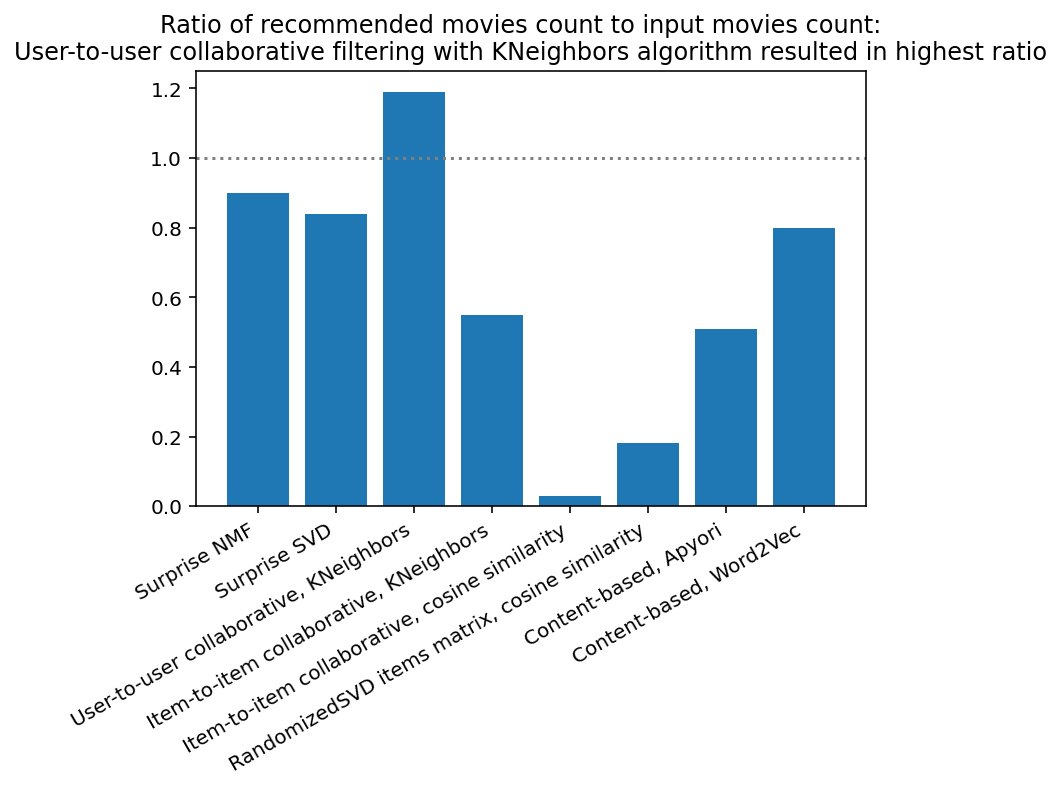

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 100
fig, ax = plt.subplots()

ax.axhline(y=1, ls=':', color='grey')
ax.bar(x=ratio.index, height=ratio.values)
plt.xticks(rotation=30, ha='right')
fig.suptitle('Ratio of recommended movies count to input movies count:')
ax.set(title='User-to-user collaborative filtering with KNeighbors algorithm resulted in highest ratio')

In [ ]:
fig.savefig('/content/drive/MyDrive/data exercises/W10/netflix-challenge/Exp1_barchart.png', bbox_inches='tight')